In [1]:
import pandas as pd
import numpy as np

In [17]:
# First Dataset
df1 = pd.read_csv("merged.csv")
df1

,Unnamed: 0,Unnamed: 0.1,TBL,msi_status,fraction_genome_altered,aneuploidy_score,TMB,TP53,KRAS,BRAF,...,RBKS,LOC100287015,KDM8,DUSP28,ZBTB49,ZNF79,FAM111A-DT,TTLL11,GPR89A,PSPN
0,0,TCGA-3L-AA1B-01A,19,MSS,0.114119,6,118,WT,WT,SNV,...,146.0,226.0,225.0,248.0,449.0,220.0,265.0,150.0,173.0,155.0
1,1,TCGA-4N-A93T-01A,38,MSS,0.311631,12,81,SNV,SNV,WT,...,196.0,166.0,135.0,309.0,260.0,203.0,286.0,176.0,183.0,287.0
2,2,TCGA-5M-AAT4-01A,87,MSS,0.422921,13,159,SNV,SNV,WT,...,196.0,246.0,160.0,267.0,268.0,212.0,171.0,190.0,231.0,225.0
3,3,TCGA-5M-AAT5-01A,28,MSI-L,0.357734,12,72,SNV,WT,WT,...,138.0,147.0,157.0,170.0,177.0,121.0,222.0,124.0,190.0,247.0
4,4,TCGA-5M-AAT6-01A,3,MSI-H,0.049432,2,1828,WT,SNV,WT,...,129.0,161.0,150.0,106.0,170.0,147.0,145.0,118.0,135.0,133.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,430,TCGA-QL-A97D-01A,104,MSS,0.309643,9,209,SNV,SNV,WT,...,120.0,239.0,124.0,146.0,194.0,170.0,190.0,206.0,253.0,184.0
431,431,TCGA-RU-A8FL-01A,105,MSS,0.270808,10,115,SNV,WT,WT,...,246.0,184.0,163.0,308.0,408.0,159.0,125.0,100.0,320.0,107.0
432,432,TCGA-SS-A7HO-01A,82,MSS,0.408573,15,143,SNV,SNV,WT,...,152.0,605.0,425.0,312.0,268.0,164.0,306.0,265.0,182.0,156.0
433,433,TCGA-T9-A92H-01A,115,MSS,0.178141,6,150,SNV,WT,WT,...,343.0,616.0,428.0,225.0,177.0,145.0,264.0,213.0,182.0,186.0


# Logistic regression using oversampling and cross validation

In [8]:
# Selecting gene expression and labels
X = df1.iloc[:, 12:]
y = df1.iloc[:, 3]

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
##add validation

In [10]:
#oversampling
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df1['msi_status_encoded'] = label_encoder.fit_transform(df1['msi_status'])
y = df1['msi_status_encoded']
X = df1.drop(['Unnamed: 0.1', 'msi_status', 'msi_status_encoded','Unnamed: 0','TBL','fraction_genome_altered','aneuploidy_score','TMB'], axis=1)
X = X.select_dtypes(include=[np.number])
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, k_neighbors=1)  
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [11]:
# Create a logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

In [12]:
from sklearn.model_selection import StratifiedKFold
# Define cross-validation strategy (Stratified K-Fold with 5 folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [13]:
# Initialize lists to store results
accuracy_scores = []
classification_reports = []

In [14]:
# Perform cross-validation
for train_index, test_index in cv.split(X_resampled, y_resampled):
    #X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    #y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Train the model
    model.fit(X_resampled, y_resampled)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    classification_report_output = classification_report(y_test, y_pred)

    # Store results
    accuracy_scores.append(accuracy)
    classification_reports.append(classification_report_output)

In [15]:
# Print the average results over all folds
# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"Average Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}")
#print("Average Classification Report:\n", pd.DataFrame(classification_reports).mean())
print("Classification Report:\n", classification_report_output)

Confusion Matrix:
[[11  0  2]
 [ 0  3 11]
 [ 2 18 40]]
Average Accuracy: 0.62
Classification Report:
               precision    recall  f1-score   support

       MSI-H       0.85      0.85      0.85        13
       MSI-L       0.14      0.21      0.17        14
         MSS       0.75      0.67      0.71        60

    accuracy                           0.62        87
   macro avg       0.58      0.58      0.58        87
weighted avg       0.67      0.62      0.64        87



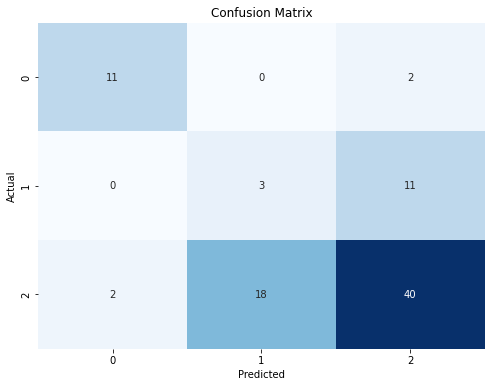

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt


# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()